In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv", on_bad_lines='skip', engine='python')
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

In [5]:
df.duplicated().sum()

0

In [6]:
df.drop_duplicates(inplace=True)


In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
df.info

<bound method DataFrame.info of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1

In [9]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [10]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

# This means that the transaction has a very large value, reaching 80 million, and it is normal and not fraudulent.

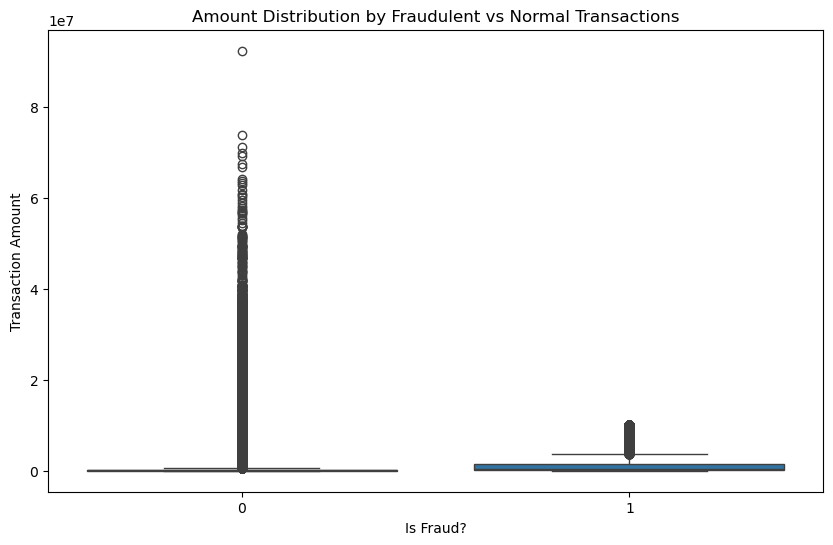

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="isFraud", y="amount", data=df)
plt.title("Amount Distribution by Fraudulent vs Normal Transactions")
plt.xlabel("Is Fraud?")
plt.ylabel("Transaction Amount")
plt.show()

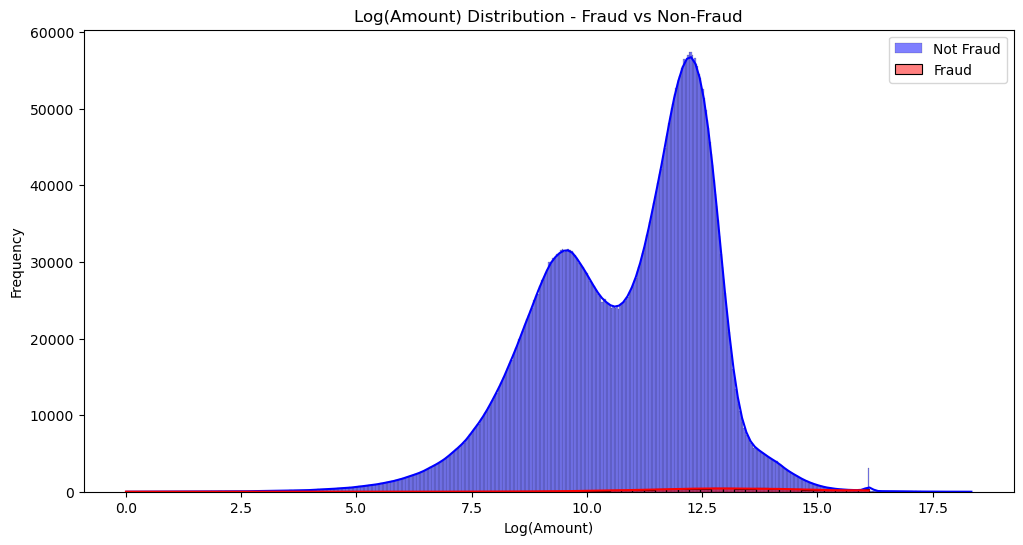

In [12]:
df['log_amount'] = df['amount'].apply(lambda x: np.log1p(x)) 
plt.figure(figsize=(12,6))
sns.histplot(df[df['isFraud']==0]['log_amount'], color='blue', label='Not Fraud', kde=True)
sns.histplot(df[df['isFraud']==1]['log_amount'], color='red', label='Fraud', kde=True)
plt.title("Log(Amount) Distribution - Fraud vs Non-Fraud")
plt.xlabel("Log(Amount)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


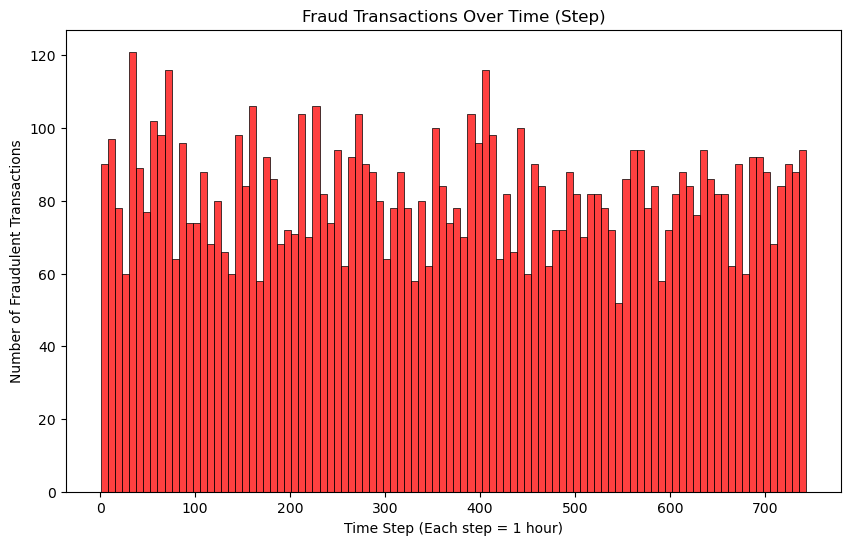

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['isFraud'] == 1], x='step', bins=100, color='red')
plt.title("Fraud Transactions Over Time (Step)")
plt.xlabel("Time Step (Each step = 1 hour)")
plt.ylabel("Number of Fraudulent Transactions")
plt.show()


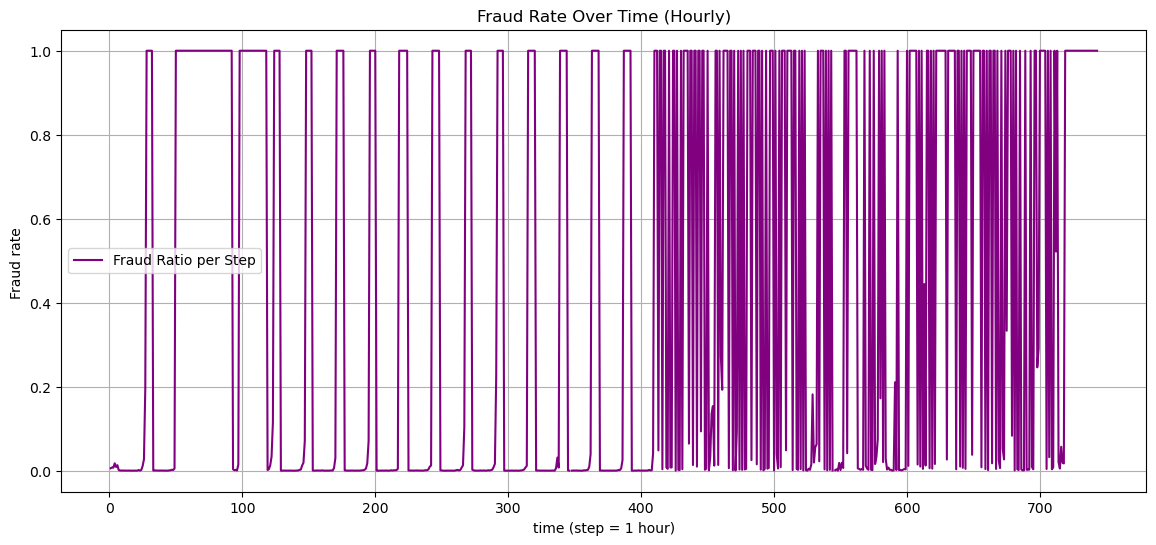

In [14]:
fraud_per_step = df[df['isFraud'] == 1].groupby('step').size()
total_per_step = df.groupby('step').size()
fraud_ratio = fraud_per_step / total_per_step
plt.figure(figsize=(14,6))
fraud_ratio.plot(color='purple', label='Fraud Ratio per Step')
plt.title("Fraud Rate Over Time (Hourly)")
plt.xlabel("time (step = 1 hour)")
plt.ylabel("Fraud rate ")
plt.legend()
plt.grid(True)
plt.show()


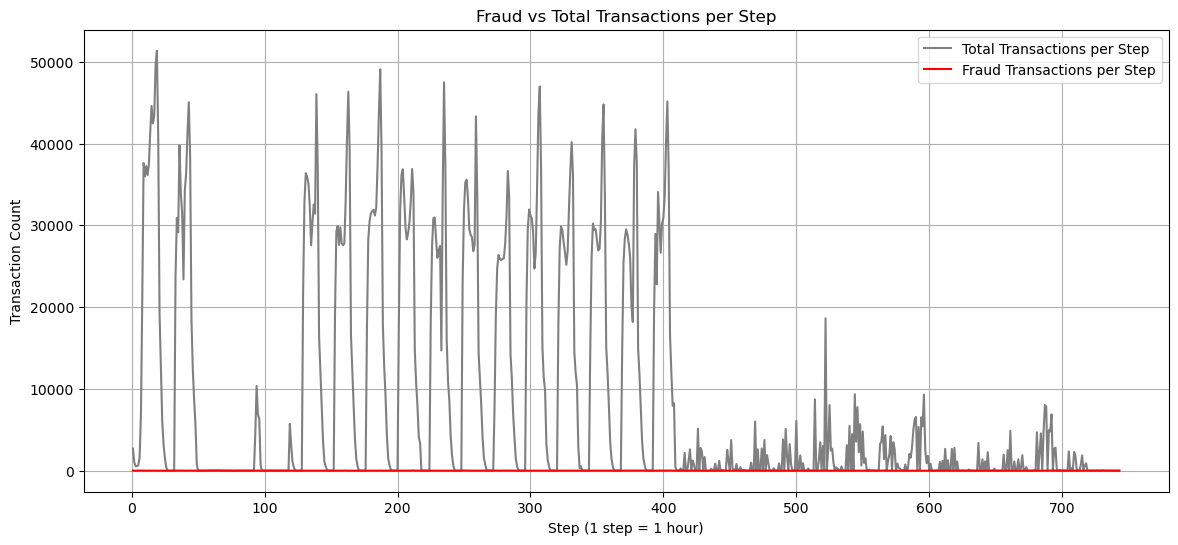

In [15]:
plt.figure(figsize=(14, 6))
total_per_step.plot(label='Total Transactions per Step', color='gray')
fraud_per_step.plot(label='Fraud Transactions per Step', color='red')
plt.title("Fraud vs Total Transactions per Step")
plt.xlabel("Step (1 step = 1 hour)")
plt.ylabel("Transaction Count")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
fraud_df = df[df['isFraud'] == 1]
normal_df = df[df['isFraud'] == 0]
normal_sample = normal_df.sample(n= 4376455, random_state=42)
new_df = pd.concat([fraud_df, normal_sample])
new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(new_df['isFraud'].value_counts())

isFraud
0    4376455
1       8213
Name: count, dtype: int64


In [17]:
print(new_df.dtypes)

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
log_amount        float64
dtype: object


In [18]:
new_df = new_df.drop(['nameOrig', 'nameDest'], axis=1)

new_df['oldbalanceOrg'] = pd.to_numeric(new_df['oldbalanceOrg'], errors='coerce')
new_df['oldbalanceDest'] = pd.to_numeric(new_df['oldbalanceDest'], errors='coerce')

new_df = pd.DataFrame({
    'transaction_id': [1, 2, 3, 4, 5],
    'type': ['PAYMENT', 'TRANSFER', 'DEBIT', 'CASH_OUT', 'PAYMENT'],
    'amount': [1000.0, 2500.0, 500.0, 3000.0, 700.0]
})
final_data = pd.get_dummies(df, columns=['type'], drop_first=True)


In [19]:
print(final_data.head())
final_data['isFraud'].value_counts()

   step    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  \
0     1   9839.64  C1231006815       170136.0       160296.36  M1979787155   
1     1   1864.28  C1666544295        21249.0        19384.72  M2044282225   
2     1    181.00  C1305486145          181.0            0.00   C553264065   
3     1    181.00   C840083671          181.0            0.00    C38997010   
4     1  11668.14  C2048537720        41554.0        29885.86  M1230701703   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  log_amount  \
0             0.0             0.0        0               0    9.194276   
1             0.0             0.0        0               0    7.531166   
2             0.0             0.0        1               0    5.204007   
3         21182.0             0.0        1               0    5.204007   
4             0.0             0.0        0               0    9.364703   

   type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0          False       Fal

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [20]:
print(final_data.columns)

Index(['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'log_amount', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')


In [21]:
final_df = final_data.drop(['nameOrig', 'nameDest'], axis=1)

final_df['oldbalanceOrg'] = pd.to_numeric(final_df['oldbalanceOrg'], errors='coerce')
final_df['oldbalanceDest'] = pd.to_numeric(final_df['oldbalanceDest'], errors='coerce')

In [22]:
print(final_df.columns)


Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'log_amount',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')


In [23]:
print(final_df.dtypes)

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
log_amount        float64
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object


In [ ]:
test_df = final_df.sample(frac=0.2, random_state=42) 
# test_df.to_csv("test_data.csv", index=False)

In [25]:
# Remove test_df rows from final_df
train_df = final_df.drop(test_df.index)

# Optional: reset index if needed
train_df = train_df.reset_index(drop=True)

In [26]:
# 1. Separate fraud and non-fraud
fraud_df = train_df[train_df['isFraud'] == 1]
nonfraud_df = train_df[train_df['isFraud'] == 0]

# 2. Choose a downsampling ratio (e.g. 1 fraud : 10 non-fraud)
ratio = 10
n_fraud = len(fraud_df)
nonfraud_sample = nonfraud_df.sample(n=n_fraud * ratio, random_state=42)

# 3. Combine fraud and downsampled non-fraud
balanced_df = pd.concat([fraud_df, nonfraud_sample])

# 4. Shuffle the new dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)



In [27]:
# Separate features and target
X = balanced_df.drop("isFraud", axis=1)
y = balanced_df["isFraud"]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [28]:
# Train/Validation/Test split — stratified and fixed
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
# Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict probabilities from XGBoost
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]


c:\Users\Kimo Store\anaconda3\envs\test\lib\site-packages\xgboost\core.py:158: UserWarning: [02:45:31] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [30]:
# Choose a threshold optimized for recall
threshold = 0.6
ensemble_preds = (xgb_probs > threshold).astype(int)

# Evaluation
print("Ensemble Classification Report:")
print(classification_report(y_test, ensemble_preds, digits=4))


Ensemble Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9924    0.9961     13186
           1     0.9294    0.9985    0.9627      1319

    accuracy                         0.9930     14505
   macro avg     0.9646    0.9954    0.9794     14505
weighted avg     0.9934    0.9930    0.9931     14505



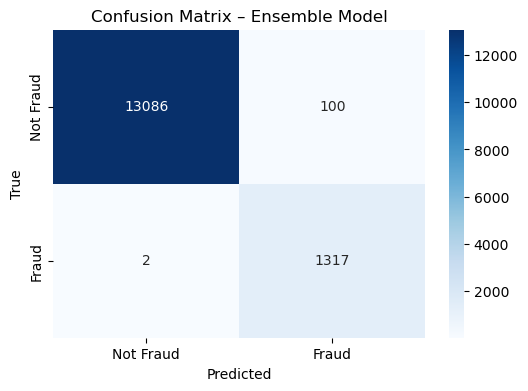

In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, ensemble_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Ensemble Model")
plt.show()

In [32]:
# Save the model to a file
xgb_model.save_model("xgb_fraud_model.json")